In [1]:
# Importing all the libraries in
import torch # Import pytorch
import torch.nn as nn # For creating Neural Network Models
import torch.nn.functional as F #
import torch.optim as optim # Importing optimizer from pytorch library
from torchvision import datasets, transforms # Importing datasets and transform function to run over the dataset
# !pip install torchsummary # Installing Torch summary to view the model summary
from torchsummary import summary # Importing the summary function from the installed torchsummary library
from tqdm.auto import tqdm
%matplotlib inline
import matplotlib.pyplot as plt # To plot graphs

In [2]:
  # checking if Cuda is available, it is available it returns True, else returns False
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu") # Assign Device to Cuda or CPU based on avaiablily

torch.manual_seed(1)
# if cuda:
torch.cuda.manual_seed(1)
device

device(type='cuda')

In [3]:
# current Batch size is set to 128, meaning the dataset will be split in different batches,
# each batch will contain 128 datapoints or here images.
batch_size = 128

# Calling a Dataloader function that takes in the dataset, batchsize and shuffle.
# Here the dataset is mnist and is loaded from the datasets function loaded from
# torch vision library
train_loader = torch.utils.data.DataLoader(
    # loading MNIST dataset to data directory, train is true therefore loading the
    # dataset from the training directory, download is true indicating the data needs
    # to be downloaded. Performing a Transformation Operation, here there are two operations
    # ToTensor and Normalize and each is performed one after the other. ToTensor operation is
    # used to convert it tensor and Normalize takes in mean and std of the dataset to normalize
    # in the input image. shuffle indicates the data will be loaded randomly
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        # transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
                        # transforms.Resize((28, 28)),
                        # transforms.RandomRotation((-15., 15.), fill=0),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,)
                        ) # these are the MNIST dataset mean and std values of dataset set
                    ])),

    batch_size=batch_size, shuffle=True,num_workers = 4,pin_memory = True)
  # Performing the same operation to create the test data, therefore train is set to false and
  # is loaded to test_loader
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,)) # these are the MNIST dataset mean and std values of training set
                    ])),
    batch_size=batch_size, shuffle=True,num_workers = 4,pin_memory = True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [4]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model:nn.Module, device:torch.device, train_loader, optimizer, epoch):
    # Putting the model to train mode
    model.train()

    # Loading train dtaloader to Tqdm to produce output in bar for
    # visual interpretation.
    correct = 0
    processed = 0
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        # adding data and target label to cuda
        data, target = data.to(device), target.to(device)
        # print("\nData Shape:",data.shape)
        # making all the gradients zero before forward propogation
        optimizer.zero_grad()
        # print("Target Shape:",target.shape)
        # loading data to model
        output = model(data)
        # print("output Shape:",output.shape)

        # calculating loss with output and target using negative log likelyhood loss
        loss = F.nll_loss(output, target)
        train_losses.append(loss)

        # calcualting back propogation
        loss.backward()

        # Revaulating the model and updating the gradient
        optimizer.step()

        pred = output.argmax(dim=1,keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx} Accuracy = {100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)
        # break
    # print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    #     test_loss, correct, len(test_loader.dataset),
    #     100. * correct / len(test_loader.dataset)))


def test(model, device, test_loader):
    # Putting the model to eval mode
    model.eval()

    # Test_loss is kept to 0
    test_loss = 0

    # correct value
    correct = 0
    # Loading model without gradient
    with torch.no_grad():
        # Load test model
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            # Running model to testing data
            output = model(data)
            # calculating testing call
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss

            # calculating prediction
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            # checking all the correct predictions
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_acc.append(100. * correct / len(test_loader.dataset))

In [5]:
DROPOUT_VALUE = 0
class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 7, kernel_size=3,bias = True)
        self.conv2 = nn.Conv2d(7, 16, kernel_size=3,bias = True)
        # self.conv3 = nn.Conv2d(12, 12, kernel_size=3,bias = False)
        self.conv4 = nn.Conv2d(16, 12, kernel_size=1,bias = True)
        self.conv5 = nn.Conv2d(12, 16, kernel_size=3,bias = True)
        self.conv6 = nn.Conv2d(16, 16, kernel_size=3,bias = True)
        self.conv7 = nn.Conv2d(16, 16, kernel_size=3,bias = True)
        # self.conv8 = nn.Conv2d(11, 11, kernel_size=3,bias = False)
        self.conv9 = nn.Conv2d(16, 10, kernel_size=1,bias = True)
        self.batch1 = nn.BatchNorm2d(7)
        self.batch2 = nn.BatchNorm2d(16)
        self.batch3 = nn.BatchNorm2d(16)
        self.batch4 = nn.BatchNorm2d(16)
        self.batch5 = nn.BatchNorm2d(16)
        self.batch6 = nn.BatchNorm2d(16)
        self.batch7 = nn.BatchNorm2d(16)
        # self.batch8 = nn.BatchNorm2d(8)
        self.pool = nn.MaxPool2d(2,2)
        self.dropout1 = nn.Dropout2d(DROPOUT_VALUE)
        self.dropout2 = nn.Dropout2d(DROPOUT_VALUE)
        self.dropout3 = nn.Dropout2d(DROPOUT_VALUE)
        self.dropout4 = nn.Dropout2d(DROPOUT_VALUE)
        self.dropout5 = nn.Dropout2d(DROPOUT_VALUE)
        self.dropout6 = nn.Dropout2d(DROPOUT_VALUE)
        self.dropout7 = nn.Dropout2d(DROPOUT_VALUE)
        self.avgpool = nn.AvgPool2d(5)

    def forward(self, x):
        x = self.dropout1(self.batch1(F.relu(self.conv1(x))))
        x = self.dropout2(self.batch2(F.relu(self.conv2(x))))
        # x = self.dropout3(self.batch3(F.relu(self.conv3(x))))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.dropout4(self.batch4(F.relu(self.conv5(x))))
        x = self.dropout5(self.batch5(F.relu(self.conv6(x))))
        x = self.dropout6(self.batch6(F.relu(self.conv7(x))))
        # x = self.dropout7(self.batch7(F.relu(self.conv8(x))))
        x = self.avgpool(self.conv9(x))
        x = x.view(-1,10)

        return F.log_softmax(x, dim=-1)

# loading Neural Network to device
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 7, 26, 26]              70
       BatchNorm2d-2            [-1, 7, 26, 26]              14
         Dropout2d-3            [-1, 7, 26, 26]               0
            Conv2d-4           [-1, 16, 24, 24]           1,024
       BatchNorm2d-5           [-1, 16, 24, 24]              32
         Dropout2d-6           [-1, 16, 24, 24]               0
            Conv2d-7           [-1, 12, 24, 24]             204
         MaxPool2d-8           [-1, 12, 12, 12]               0
            Conv2d-9           [-1, 16, 10, 10]           1,744
      BatchNorm2d-10           [-1, 16, 10, 10]              32
        Dropout2d-11           [-1, 16, 10, 10]               0
           Conv2d-12             [-1, 16, 8, 8]           2,320
      BatchNorm2d-13             [-1, 16, 8, 8]              32
        Dropout2d-14             [-1, 1

In [6]:
# Loading Stochastic gradient descent optimzer with momentum with learning as 0.01 and momentum as 0.9.
model = Net().to(device)
# summary(model, input_size=(1, 28, 28))
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1, verbose=False)
#running the model for one epoch
for epoch in range(1, 16):
    # calling the train the function that takes in model, device,
    # train_loader, optimzer and epoch as input
    print("Epoch:",epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    # calling the test the function that takes in model, device,
    # test_loader as input
    test(model, device, test_loader)

Epoch: 1


loss=0.09583064168691635 batch_id=468 Accuracy = 89.05: 100%|██████████| 469/469 [00:31<00:00, 14.84it/s]



Test set: Average loss: 0.0715, Accuracy: 9820/10000 (98.20%)

Epoch: 2


loss=0.04321979358792305 batch_id=468 Accuracy = 97.37: 100%|██████████| 469/469 [00:25<00:00, 18.08it/s]



Test set: Average loss: 0.0536, Accuracy: 9863/10000 (98.63%)

Epoch: 3


loss=0.06086182966828346 batch_id=468 Accuracy = 98.01: 100%|██████████| 469/469 [00:25<00:00, 18.12it/s]



Test set: Average loss: 0.0386, Accuracy: 9883/10000 (98.83%)

Epoch: 4


loss=0.03211347386240959 batch_id=468 Accuracy = 98.25: 100%|██████████| 469/469 [00:26<00:00, 17.56it/s]



Test set: Average loss: 0.0400, Accuracy: 9879/10000 (98.79%)

Epoch: 5


loss=0.049990613013505936 batch_id=468 Accuracy = 98.42: 100%|██████████| 469/469 [00:27<00:00, 17.14it/s]



Test set: Average loss: 0.0271, Accuracy: 9921/10000 (99.21%)

Epoch: 6


loss=0.07416544109582901 batch_id=468 Accuracy = 98.61: 100%|██████████| 469/469 [00:26<00:00, 17.59it/s]



Test set: Average loss: 0.0297, Accuracy: 9919/10000 (99.19%)

Epoch: 7


loss=0.02841780334711075 batch_id=468 Accuracy = 98.62: 100%|██████████| 469/469 [00:26<00:00, 17.88it/s]



Test set: Average loss: 0.0318, Accuracy: 9897/10000 (98.97%)

Epoch: 8


loss=0.013437452726066113 batch_id=468 Accuracy = 98.70: 100%|██████████| 469/469 [00:27<00:00, 17.27it/s]



Test set: Average loss: 0.0257, Accuracy: 9923/10000 (99.23%)

Epoch: 9


loss=0.0197892002761364 batch_id=468 Accuracy = 98.92: 100%|██████████| 469/469 [00:29<00:00, 15.70it/s]



Test set: Average loss: 0.0209, Accuracy: 9937/10000 (99.37%)

Epoch: 10


loss=0.056764546781778336 batch_id=468 Accuracy = 98.98: 100%|██████████| 469/469 [00:27<00:00, 17.21it/s]



Test set: Average loss: 0.0206, Accuracy: 9940/10000 (99.40%)

Epoch: 11


loss=0.015227423049509525 batch_id=468 Accuracy = 99.07: 100%|██████████| 469/469 [00:26<00:00, 17.82it/s]



Test set: Average loss: 0.0199, Accuracy: 9940/10000 (99.40%)

Epoch: 12


loss=0.054361552000045776 batch_id=468 Accuracy = 98.98: 100%|██████████| 469/469 [00:25<00:00, 18.20it/s]



Test set: Average loss: 0.0197, Accuracy: 9944/10000 (99.44%)

Epoch: 13


loss=0.047301024198532104 batch_id=468 Accuracy = 99.06: 100%|██████████| 469/469 [00:26<00:00, 17.98it/s]



Test set: Average loss: 0.0199, Accuracy: 9942/10000 (99.42%)

Epoch: 14


loss=0.026556359604001045 batch_id=468 Accuracy = 99.05: 100%|██████████| 469/469 [00:26<00:00, 17.70it/s]



Test set: Average loss: 0.0194, Accuracy: 9945/10000 (99.45%)

Epoch: 15


loss=0.005879692267626524 batch_id=468 Accuracy = 99.08: 100%|██████████| 469/469 [00:27<00:00, 17.25it/s]



Test set: Average loss: 0.0192, Accuracy: 9941/10000 (99.41%)



In [7]:
type(train_losses)

list

Text(0.5, 1.0, 'Test Accuracy')

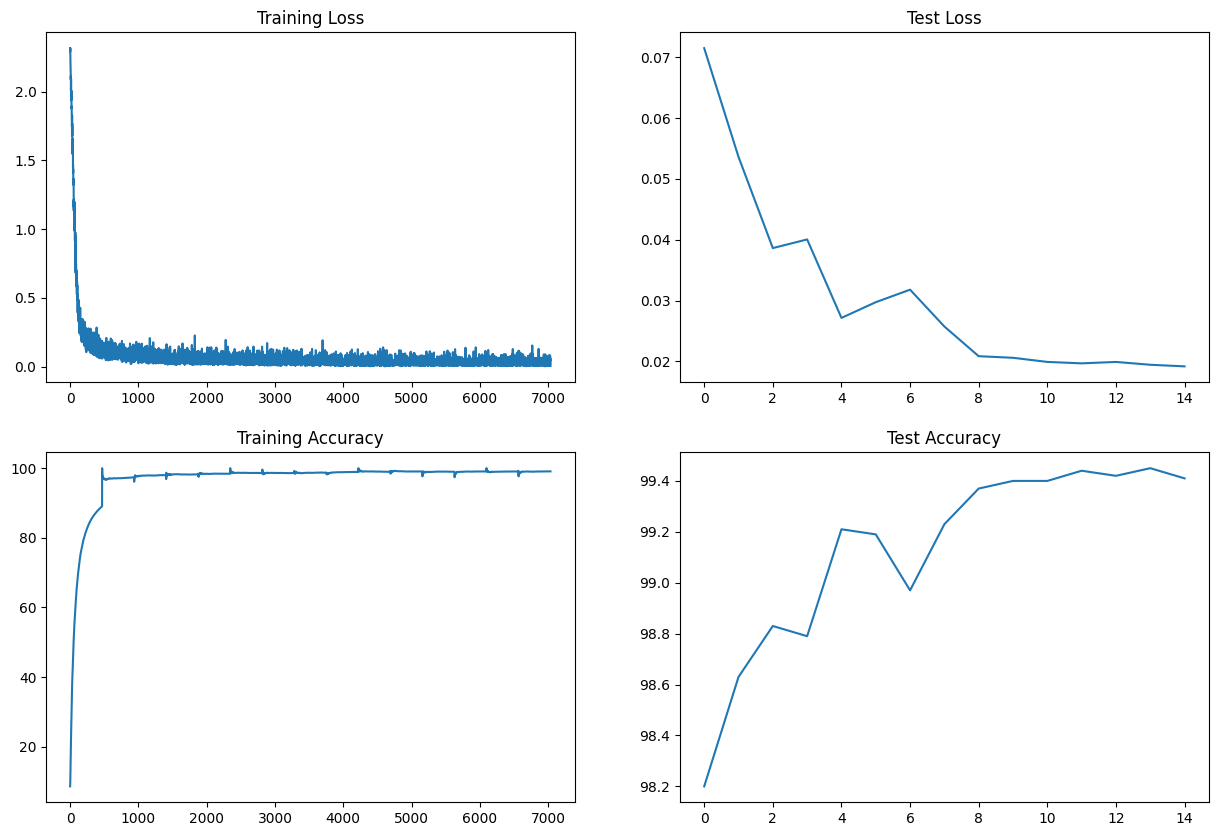

In [8]:
train_losses = [t_items.item() for t_items in train_losses]
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [9]:
# Rerun to check it wasnt a fluke

# Loading Stochastic gradient descent optimzer with momentum with learning as 0.01 and momentum as 0.9.
model =  Net().to(device)
summary(model, input_size=(1, 28, 28))
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)
train_losses = []
test_losses = []
train_acc = []
test_acc = []
for epoch in range(1,16):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 7, 26, 26]              70
       BatchNorm2d-2            [-1, 7, 26, 26]              14
         Dropout2d-3            [-1, 7, 26, 26]               0
            Conv2d-4           [-1, 16, 24, 24]           1,024
       BatchNorm2d-5           [-1, 16, 24, 24]              32
         Dropout2d-6           [-1, 16, 24, 24]               0
            Conv2d-7           [-1, 12, 24, 24]             204
         MaxPool2d-8           [-1, 12, 12, 12]               0
            Conv2d-9           [-1, 16, 10, 10]           1,744
      BatchNorm2d-10           [-1, 16, 10, 10]              32
        Dropout2d-11           [-1, 16, 10, 10]               0
           Conv2d-12             [-1, 16, 8, 8]           2,320
      BatchNorm2d-13             [-1, 16, 8, 8]              32
        Dropout2d-14             [-1, 1

loss=0.20113860070705414 batch_id=468 Accuracy = 87.74: 100%|██████████| 469/469 [00:26<00:00, 17.78it/s]



Test set: Average loss: 0.0836, Accuracy: 9787/10000 (97.87%)

EPOCH: 2


loss=0.09470514208078384 batch_id=468 Accuracy = 97.19: 100%|██████████| 469/469 [00:26<00:00, 17.46it/s]



Test set: Average loss: 0.0555, Accuracy: 9848/10000 (98.48%)

EPOCH: 3


loss=0.04006436467170715 batch_id=468 Accuracy = 97.89: 100%|██████████| 469/469 [00:26<00:00, 17.43it/s]



Test set: Average loss: 0.0393, Accuracy: 9893/10000 (98.93%)

EPOCH: 4


loss=0.12767216563224792 batch_id=468 Accuracy = 98.14: 100%|██████████| 469/469 [00:26<00:00, 17.59it/s]



Test set: Average loss: 0.0381, Accuracy: 9882/10000 (98.82%)

EPOCH: 5


loss=0.018000459298491478 batch_id=468 Accuracy = 98.33: 100%|██████████| 469/469 [00:26<00:00, 17.66it/s]



Test set: Average loss: 0.0316, Accuracy: 9905/10000 (99.05%)

EPOCH: 6


loss=0.025490468367934227 batch_id=468 Accuracy = 98.60: 100%|██████████| 469/469 [00:26<00:00, 17.45it/s]



Test set: Average loss: 0.0273, Accuracy: 9924/10000 (99.24%)

EPOCH: 7


loss=0.17539161443710327 batch_id=468 Accuracy = 98.51: 100%|██████████| 469/469 [00:27<00:00, 17.23it/s]



Test set: Average loss: 0.0267, Accuracy: 9924/10000 (99.24%)

EPOCH: 8


loss=0.06139170750975609 batch_id=468 Accuracy = 98.67: 100%|██████████| 469/469 [00:28<00:00, 16.41it/s]



Test set: Average loss: 0.0250, Accuracy: 9925/10000 (99.25%)

EPOCH: 9


loss=0.004190119449049234 batch_id=468 Accuracy = 98.97: 100%|██████████| 469/469 [00:27<00:00, 16.86it/s]



Test set: Average loss: 0.0207, Accuracy: 9940/10000 (99.40%)

EPOCH: 10


loss=0.007200026419013739 batch_id=468 Accuracy = 99.01: 100%|██████████| 469/469 [00:27<00:00, 17.06it/s]



Test set: Average loss: 0.0199, Accuracy: 9940/10000 (99.40%)

EPOCH: 11


loss=0.006030406337231398 batch_id=468 Accuracy = 99.00: 100%|██████████| 469/469 [00:27<00:00, 16.90it/s]



Test set: Average loss: 0.0198, Accuracy: 9941/10000 (99.41%)

EPOCH: 12


loss=0.006296748761087656 batch_id=468 Accuracy = 99.02: 100%|██████████| 469/469 [00:28<00:00, 16.56it/s]



Test set: Average loss: 0.0195, Accuracy: 9943/10000 (99.43%)

EPOCH: 13


loss=0.015938229858875275 batch_id=468 Accuracy = 98.97: 100%|██████████| 469/469 [00:27<00:00, 17.00it/s]



Test set: Average loss: 0.0188, Accuracy: 9945/10000 (99.45%)

EPOCH: 14


loss=0.01874803937971592 batch_id=468 Accuracy = 99.06: 100%|██████████| 469/469 [00:27<00:00, 17.34it/s]



Test set: Average loss: 0.0187, Accuracy: 9944/10000 (99.44%)

EPOCH: 15


loss=0.1066778302192688 batch_id=468 Accuracy = 99.08: 100%|██████████| 469/469 [00:27<00:00, 17.24it/s]



Test set: Average loss: 0.0194, Accuracy: 9940/10000 (99.40%)



Text(0.5, 1.0, 'Test Accuracy')

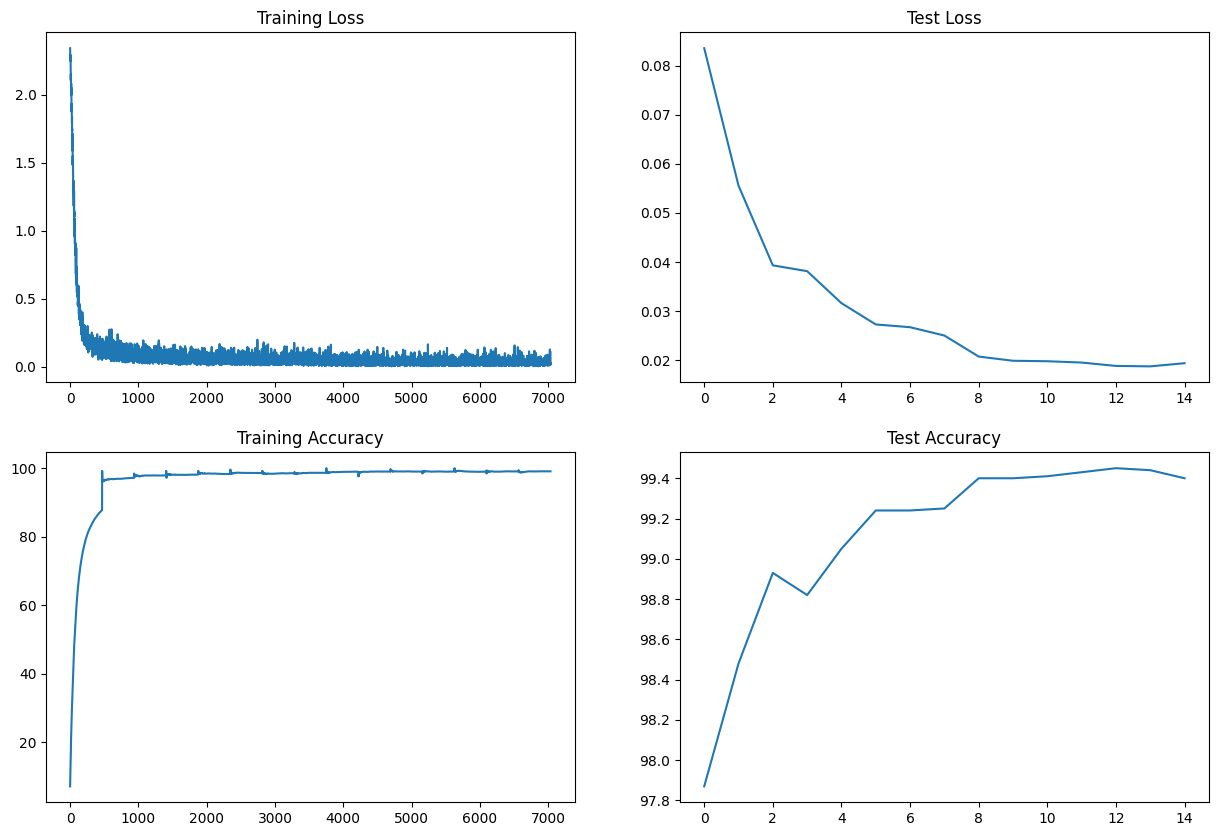

In [10]:
train_losses = [t_items.item() for t_items in train_losses]
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")